# Word Mover's Distance and Concept Mover's Distance

Texts produced by social actors of interest might engage with or invoke the idea of "community" to varying degrees. Here I adapt one method for comparing or ranking texts by their degree of engagement with a concept, and I demonstrate its face validity on an obvious test case. I raise a few questions about further validation and possible alternative methods for document-level comparison.

Beyond comparing words to each other, word embeddings can be used to compare entire texts. These "documents" might be sentences, paragraphs, or entire articles. One method to do this comparison is Word Mover's Distance (WMD), which Stoltz and Taylor (2019, 2020) have extended and applied to social-scientific concepts as Concept Mover's Distance (CMD). For CMD, the second "document" in the comparison is one word or a few words representing a "concept", rather than a natural text.

WMD is potentially useful (as Stoltz and Taylor, among others, explain) because texts can have similar meanings even when they use different words. When people write or talk about a sense of community, for instance, they won't necessarily use the word "community" itself -- they might say "belonging", or "home", or "togetherness" instead. Embeddings encode that underlying similarity in meaning. 

I need texts that are clearly about community, texts that are clearly related to community, and texts that are about something else entirely. I'll use Wikipedia articles. The [article about "community"](https://en.wikipedia.org/wiki/Community) ought to be one of the most similar to the "community" concept vector. I'd expect it to be more similar to "community" (the concept) than related articles (the [article about "society"](https://en.wikipedia.org/wiki/Society), for instance), which in turn I'd expect to be closer than articles chosen at random. 

Wikipedia articles are an attractive choice because they're written in a consistent, collective voice and because they have explicit focal topics. In a way, they're also a sort of "in-sample" test, because one set of pretrained GloVe vectors is trained primarily on Wikipedia data. (A useful extension might be to substitute the model trained on Twitter data instead. I might expect that using the Twitter model on "out-of-sample" data would produce a lower-quality or less relevant ranking.) 

Ranking articles by WMD / CMD by their similarity to "community" is a simple test of whether this method can be usefully applied to the case of community at all. This is something Stoltz and Taylor (2019) propose in passing, suggesting that sermons be measured for engagement with community, and then correlated with participatory outcomes like volunteering. (That view of community incidentally strikes me as aligned with Putnam's work on social capital.) With a new method, though, I can't take its utility for a new substantive case for granted.

I also don't want to overestimate my understanding. Translating [Stoltz and Taylor's CMD approach](https://github.com/dustinstoltz/CMDist) from R to Python for use with the gensim package confirms that I do in fact understand the method. In addition to CMDist, I rely on the [gensim WMD tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html). 

Finally, this simple implementation points to where I still have questions. For instance, I still think paragraph vectors (also known as doc2vec) might be a useful alternative for calculating distances between documents -- which is the basic WMD use case. That's why [I've used that approach in the past](https://github.com/ccgilroy/pols559-project/). The major downside seems to be that you can't use pretrained vectors with doc2vec; you have to train your own model on your own collection of documents. I'd wonder if doc2vec could be used to compare entire documents to individual words, analogously to CMD, or if it could be integrated with pretrained vectors somehow. Note that gensim (Python) has a doc2vec implementation; text2vec (R) doesn't, which is a barrier for social scientists working in R.

I'll proceed by loading everything I need -- packages, pretrained vectors, and Wikipedia articles -- preprocessing the documents, and then calculating WMD/CMD in a few different ways. The main figure ranks 6 articles by how similar they are to the community concept. Some notes on the methods follow at the end.

In [1]:
# load packages
import gensim.downloader as api
import wikipedia

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [2]:
# load vectors
wv_wiki = api.load('glove-wiki-gigaword-200')

# norm vectors
# TODO: replace with .fill_norms() in gensim 4.0.0
wv_wiki.init_sims(replace=True)

In [3]:
# load articles
wikipedia.set_rate_limiting(rate_limit=True)

In [4]:
wikipedia.summary("Community")

'A community is a social unit (a group of living things) with commonality such as norms, religion, values, customs, or identity.  Communities may share a sense of place situated in a given geographical area (e.g. a country, village, town, or neighbourhood) or in virtual space through communication platforms. Durable relations that extend beyond immediate genealogical ties also define a sense of community, important to their identity, practice, and roles in social institutions such as family, home, work, government, society, or humanity at large. Although communities are usually small relative to personal social ties, "community" may also refer to large group affiliations such as national communities, international communities, and virtual communities.The English-language word "community" derives from the Old French comuneté (currently "Communauté"), which comes from the Latin communitas "community", "public spirit" (from Latin communis, "common").Human communities may have intent, beli

In [5]:
# I wrote code a couple years ago for turning multiple Wikipedia pages
# into a dataframe. I can resurrect that if I need to.
wiki_community = wikipedia.page("Community")

In [6]:
# a related article
wiki_society = wikipedia.page("Society")

In [7]:
# a random wikipedia article
# this was the featured article on 2020-12-09
wiki_cleo = wikipedia.page("Death of Cleopatra")

In [8]:
print(wiki_cleo.summary)

The death of Cleopatra VII, the last ruler of Ptolemaic Egypt, occurred on either 10 or 12 August, 30 BC, in Alexandria, when she was 39 years old. According to popular belief, Cleopatra killed herself by allowing an asp (Egyptian cobra) to bite her, but for Greek and Roman historians, Cleopatra poisoned herself using either a toxic ointment or by introducing the poison with a sharp implement such as a hairpin. Primary source accounts are derived mainly from the works of the ancient Roman historians Strabo, Plutarch, and Cassius Dio. Modern scholars debate the validity of ancient reports involving snakebites as the cause of death and if she was murdered or not. Some academics hypothesize that her Roman political rival Octavian forced her to kill herself in a manner of her choosing. The location of Cleopatra's tomb is unknown. It was recorded that Octavian allowed for her and her husband, the Roman politician and general Mark Antony, who stabbed himself with a sword, to be buried togeth

## Preprocess documents

The `gensim.KeyedVectors.wmdistance` method handles removing words from the documents that aren't in the model vocabulary, so there's no need for me to do that.

This is how Stoltz and Taylor 2019 describe their preprocessing: 

> We use standard pre-processing techniques to clean the texts, which included removing stopwords, punctuation, capitalization, numbers, and non-ASCII characters. However, we do not stem or lemmatize the words as the fastText embeddings are neither stemmed nor lemmatized and doing so needlessly reduces semantic information (and without a noticeable boost in performance).

And here's an example from their code: https://github.com/dustinstoltz/concept_movers_distance_jcss/blob/master/1_cmd_bible_cleaned.R#L16

The GloVe vectors aren't stemmed or lemmatized either, so this same preprocessing should be fine.

In fact, the gensim tutorial for WMD does essentially the same preprocessing as Stoltz and Taylor: 

```
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.
stop_words = stopwords.words('english')

def preprocess(sentence):
    return [w for w in sentence.lower().split() if w not in stop_words]
```

gensim.utils.simple_preprocess is what I've used in the past: https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess

It does most of that, but doesn't remove stopwords. I've also used `gensim.parsing.preprocessing.preprocess_documents`, which does a lot more by default (including removing stopwords, but also stemming, which I don't want).

https://radimrehurek.com/gensim/parsing/preprocessing.html

In [9]:
def filter_stopwords(words):
    stop_words = stopwords.words("english")
    return [w for w in words if w not in stop_words]

In [10]:
def preprocess(doc):
    return filter_stopwords(simple_preprocess(doc, 
                                              min_len=2, 
                                              max_len=30, 
                                              deacc=True))

In [11]:
doc_community = preprocess(wiki_community.content)
doc_society = preprocess(wiki_society.content)
doc_cleo = preprocess(wiki_cleo.content)

## Create concept pseudo-document

In [12]:
doc_concept = ["community"]

## Calculate distances

In [13]:
wv_wiki.wmdistance(doc_community, doc_concept)

1.0651109557549596

In [14]:
wv_wiki.wmdistance(doc_society, doc_concept)

1.148490316050476

In [15]:
wv_wiki.wmdistance(doc_cleo, doc_concept)

1.2857261839714176

The ordering of these three articles is as expected, though it's unclear whether the magnitude is interpretable. Once the vectors are normed, the values are pretty similar to the magnitudes reported in the WMD tutorial. Norming the vectors at the beginning (with `.init_sims()`) does change the scale.

Because Stoltz and Taylor standardize and invert their CMD values, positive values in their paper mean closer distances, and negative values are also possible.

In [16]:
# hard-coded to be 0.0, the closest possible distance
wv_wiki.wmdistance(doc_community, doc_community)

0.0

In [17]:
wv_wiki.wmdistance(doc_community, doc_society)

0.7161915664722102

Comparing two full documents is substantially slower than comparing a document and a one-word concept. I can see where the speed gains from faster algorithms would be worthwhile.

It puzzles me a bit that the community and society articles are closer to each other than to the community concept, though I suppose that makes sense in hindsight. In fact, lots of words in a wikipedia article about a sociological concept would be general social science words, or general English words, not concept-specific or concept-related words. Put differently, it's less effort to turn the Community wikipedia page into the Society wikipedia page, rather than into a page that just says "community community community..." over and over again. Is that a fair understanding of what WMD/CMD is doing?

In [18]:
# two-word concept, which yields highly similar results
doc_concept2 = ["community", "belonging"]

In [19]:
wv_wiki.wmdistance(doc_community, doc_concept2)

1.0890325554625404

In [20]:
wv_wiki.wmdistance(doc_concept, doc_concept2)

0.5885887145996094

In [21]:
wv_wiki.wmdistance(doc_society, doc_concept2)

1.1633261491646034

In [22]:
wv_wiki.wmdistance(doc_cleo, doc_concept2)

1.2630806168497222

As an extension, I'll pick a few more related articles and compare those. This helps me understand what it is about community that's getting encoded in the community vector.

community in an ecological (biological) sense: 
https://en.wikipedia.org/wiki/Community_(ecology)

sense of community (psychology): 
https://en.wikipedia.org/wiki/Sense_of_community

In [23]:
wiki_community_ecology = wikipedia.page("Community (ecology)")

In [24]:
wiki_sense_of_community = wikipedia.page("Sense of community")

In [25]:
doc_community_ecology = preprocess(wiki_community_ecology.content)

In [26]:
doc_sense_of_community = preprocess(wiki_sense_of_community.content)

In [27]:
wv_wiki.wmdistance(doc_community_ecology, doc_concept)

1.194192387622505

In [28]:
wv_wiki.wmdistance(doc_sense_of_community, doc_concept)

1.078757950145935

The "Sense of community" article is almost as close as the "Community" article to the one-word "community" concept; the "Community (ecology)" article is further from the concept than the "Society" article.

In [29]:
doc_concept3 = ['local', 'community']

In [30]:
# Wikipedia prefers the UK spelling
wiki_neighbourhood = wikipedia.page("Neighbourhood")
doc_neighbourhood = preprocess(wiki_neighbourhood.content)

In [31]:
wv_wiki.wmdistance(doc_neighbourhood, doc_concept)

1.1155348441307014

In [32]:
wv_wiki.wmdistance(doc_neighbourhood, doc_concept3)

1.0721122719869867

In [33]:
wv_wiki.wmdistance(doc_community, doc_concept3)

1.0418642175282469

Again, it's kind of counterintuitive that "refining" the concept makes a page closer to it. Are Stoltz and Taylor using an average instead? (No, they're not - see the binary axes notebook for more detailed notes.)

To produce an overall plot of word mover's distances, I'll put everything into a data frame.

In [34]:
pages = [
    wiki_community, 
    wiki_society,
    wiki_cleo,
    wiki_neighbourhood,
    wiki_sense_of_community,
    wiki_community_ecology
]

d_wiki = pd.DataFrame({'page': pages})

In [35]:
d_wiki['title'] = [p.title for p in d_wiki['page']]

In [36]:
d_wiki['doc'] = [preprocess(p.content) for p in d_wiki['page']]

In [37]:
d_wiki['wmd'] = [
    wv_wiki.wmdistance(doc, doc_concept) for doc in d_wiki['doc']
]

In [38]:
d_wiki.sort_values('wmd', inplace=True)

In [39]:
d_wiki

,page,title,doc,wmd
0,<WikipediaPage 'Community'>,Community,"[community, social, unit, group, living, thing...",1.065111
4,<WikipediaPage 'Sense of community'>,Sense of community,"[sense, community, psychological, sense, commu...",1.078758
3,<WikipediaPage 'Neighbourhood'>,Neighbourhood,"[neighbourhood, british, english, australian, ...",1.115535
1,<WikipediaPage 'Society'>,Society,"[society, group, individuals, involved, persis...",1.148490
5,<WikipediaPage 'Community (ecology)'>,Community (ecology),"[ecology, community, group, association, popul...",1.194192
2,<WikipediaPage 'Death of Cleopatra'>,Death of Cleopatra,"[death, cleopatra, vii, last, ruler, ptolemaic...",1.285726


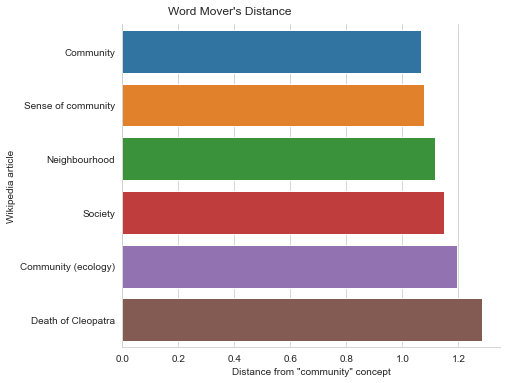

In [40]:
# I'm still learning how to make pretty plots with seaborn and matplotlib
sns.set_style("whitegrid")
fig = sns.catplot(y='title', x='wmd', kind='bar', data=d_wiki)
fig.set_axis_labels('Distance from "community" concept', 
                    'Wikipedia article')
fig.fig.suptitle("Word Mover's Distance", y=1.02)
fig.fig.set_figwidth(8)
fig.fig.set_figheight(5)
plt.show()

In [41]:
fig.savefig("img/community_wmdistance.png", dpi=600)

The ranking here is an intuitively reasonable one -- Community is the closest article, and the Death of Cleopatra, a randomly chosen article is the most distant. Among the intermediate articles, I find the ranking here consistent with what I found by investigating word similarity previously, but I can't claim that it was entirely predictable in advance. 

There isn't a clear interpretation of the magnitude, at least not without more work to investigate the distribution of WMD values and establish a well-defined baseline. It would take more comparison to know whether a distance might be thought of as small or large. My advisor suggested I might randomly generate text from some vocabulary; I'd be more inclined, at least initially, to select more actual articles at random.

The distances between each of the articles might also be worth exploring. For reasons I noted above, it seems like any two articles might be closer to each other than to any one-word concept. 

This is really only a test of face validity. I'm unsure what would constitute a real external test of accuracy. Human ranking by Mechanical Turk workers or similar is one option, commonly used, but that would seem to foreclose the possibility of letting the embeddings tell us something counterintuitive or unexpected. 

## Methods notes

### Distance metric

The R text2vec package used to use euclidean distance but then switched to cosine distance. I think gensim still uses euclidean distance. Stoltz and Taylor say this doesn't matter because it produces roughly the same results. I hope so.

`wmdistance` confirms that the distance matrix gensim uses is Euclidean. pyemd.emd expects two normalized histograms, which gensim accomplishes with normalized bags-of-words (nBOWs). 

EMD: 

- https://github.com/wmayner/pyemd
- https://en.wikipedia.org/wiki/Earth_mover%27s_distance

### Algorithm

The CMD algorithm is now "Linear-Complexity Relaxed Word Mover's Distance" rather than "Relaxed Word Mover's Distance". Again, this probably shouldn't matter, but it's good to know what's going on. I'm unsure what algorithm gensim uses, but it should be here: https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/keyedvectors.py#L842

(Oddly enough, and in contrast to the README, code comments suggest RWMD vs LC-RWMD *does* matter: https://github.com/dustinstoltz/CMDist/blob/master/R/kusnerRWMD.R. Maintaining consistent documentation is *hard*.)

Because gemsim just calls `pyemd.emd` which wraps the C implementation of the 2009 paper, I think the algorithm is just WMD, not any relaxed version, though there's some sort of speed improvement in that paper over previous EMD algorithms. This is all way out of my league in computer-science land. 

All that to say, hopefully none of these code/math details matter! But the divergence between text2vec and gensim based on which papers they're implementing is kind of fascinating. It seems like text2vec is more current, which comes as a surprise to me. (It also makes me wonder which is ultimately faster in practice, if Python is generally faster than R.)

An advantage of CMDist / text2vec seems to be that you can just plug in a document-term matrix. gensim seems to expect individual documents instead, and it constructs a vocabulary matrix each time. (Is using a dtm actually more efficient speed-wise or memory-wise, or just more convenient?)